# FDU PRML 2023 Fall Assignment 2.1

Name: <your name> 王炜
Student ID: <your student id> 21300190011

<font color='red'>**Deadline: 2023-11-20 23:59**</font>
<font color='red'>**Overall score weight: 70/100**</font>

In this semester, we are going to complete 3 assignments, each may contain **2-3 parts**. This is the second (and the last) part of the second assignment, in which we will get to implement our own Pytorch-like library.

## 1. FDUNN: your toy torch-like deep learning library (40 points)

In this assignment, you will fist implement your own torch-like deep learning library with `numpy`, named `fdunn`.

PyTorch: [Link](https://pytorch.org/)

In [16]:
# setup code, auto reload your .py file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# numpy
import numpy as np

np.random.seed(233)

In [18]:
# matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

You have to impletement several standard deep neural network modules in the `./fdunn` folder:
1.   linear/conv/pooling
2.   activation
3.   loss
4.   optim
5.   trainer

We have written most of the code for you already, and you only need to fill in the most essential parts. We have also prepared several test cases for you to check if your code works correctly.

Furthermore, you can also test the accuracy of your code by comparing its output with the output of sk-learn.

In [19]:
from fdunn.modules import base
from fdunn.modules import conv
from fdunn.modules import linear
from fdunn.modules import pooling
from fdunn.modules import activation
from fdunn.modules import loss
from fdunn.optim import base as op_base
from fdunn.optim import sgd
from fdunn import trainer
from fdunn.metrics import f1_score,accuracy

## 2. Deep Learning with Image/Text Data (20 points)

Use your fdunn lib to perform image classification on MNIST or CIFAR10 dataset.

- MNIST: http://yann.lecun.com/exdb/mnist/
- CIFAR10: https://www.cs.toronto.edu/~kriz/cifar.html

### The flatten object is for conforming the data to the linear layer, that is, flattening all data belonging to the same figure into a 1D array

In [20]:
class flatten(base.Module):
    def __init__(self):
        super().__init__()
        self.params = None
        self.grads = None

    def forward(self, data: np.ndarray):
        """data:(N,C,H,W),
        output:(N,C*H*W)"""
        self._N, self._C, self._H, self._W = data.shape
        return data.reshape(data.shape[0], -1)

    def backward(self, output_grad: np.ndarray):
        output_grad = np.stack(
            [
                output_grad[:, i * (self._H * self._W) : (i + 1) * (self._H * self._W)]
                for i in range(self._C)
            ],
            axis=1,
        )
        output_grad = np.stack(
            [
                output_grad[:, :, i * self._W : (i + 1) * self._W]
                for i in range(self._H)
            ],
            axis=2,
        )
        return output_grad

In [21]:
class CNN(base.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.train_batches = []
        self.conv1 = conv.Conv2d(
            in_channels=3, out_channels=6, kernel_size=4, stride=2, padding=2
        )
        self.act1 = activation.Sigmoid()
        self.pool1 = pooling.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = conv.Conv2d(
            in_channels=6, out_channels=10, kernel_size=2, stride=1, padding=1
        )
        self.act2 = activation.Sigmoid()
        self.pool2 = pooling.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = flatten()

        _a = self.conv1.kernel_size[0]
        _b = self.conv1.stride[0]
        _c = self.conv1.padding[0]
        _d = self.pool1.kernel_size[0]
        _e = self.pool1.stride[0]
        _f = self.conv2.kernel_size[0]
        _g = self.conv2.stride[0]
        _h = self.conv2.padding[0]
        _i = self.pool2.kernel_size[0]
        _j = self.pool2.stride[0]
        _n1 = np.floor((32 + 2 * _c - _a) / _b + 1)
        _n2 = np.floor((_n1 - _d) / _e + 1)
        _n3 = np.floor((_n2 + 2 * _h - _f) / _g + 1)
        _n4 = np.floor((_n3 - _i) / _j + 1)

        self.fn = linear.Linear(
            in_features=int(self.conv2.out_channels * _n4**2), out_features=10
        )

        self.layers = [
            self.conv1,
            self.act1,
            self.pool1,
            self.conv2,
            self.act2,
            self.pool2,
            self.flatten,
            self.fn,
        ]

        self.conv1.name = "conv1"
        self.act1.name = "act1"
        self.pool1.name = "pool1"
        self.conv2.name = "conv2"
        self.act2.name = "act2"
        self.pool2.name = "pool2"
        self.flatten.name = "flatten"
        self.fn.name = "fn"

    def fold(self, data: np.ndarray, datay: list, batch_size: int, valratio: float):
        """data: (N,3*32*32),datay: (N)
        train_batches: [(batch_size,3,32,32),...],
        trainlabels:[(batch_size)],
        valid:(N*valratio,3,32,32)
        validlabels=(N*valratio)"""
        assert (
            data.shape[0] % batch_size == 0
        ), "batch_size must be divisible by datasize"
        data1 = np.stack([data[:, :1024], data[:, 1024:2048], data[:, 2048:]], axis=1)
        data2 = np.stack(
            [data1[:, :, 32 * i : 32 * (i + 1)] for i in range(32)], axis=2
        )
        self.train_batches.extend(
            [
                data2[batch_size * i : batch_size * (i + 1)]
                for i in range(int(data.shape[0] * (1 - valratio) / batch_size))
            ]
        )
        self.valid_data = data2[
            batch_size * int(data.shape[0] * (1 - valratio) / batch_size) :
        ]
        datay = np.array(datay)
        self.trainlabels = [
            datay[batch_size * i : batch_size * (i + 1)]
            for i in range(int(data.shape[0] * (1 - valratio) / batch_size))
        ]
        self.validlabels = datay[
            batch_size * int(data.shape[0] * (1 - valratio) / batch_size) :
        ]

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fn(x)
        return x

    def backward(self, grad):
        grad = self.fn.backward(grad)
        grad = self.flatten.backward(grad)
        grad = self.pool2.backward(grad)
        grad = self.act2.backward(grad)
        grad = self.conv2.backward(grad)
        grad = self.pool1.backward(grad)
        grad = self.act1.backward(grad)
        self.conv1.backward(grad)

In [22]:
file = "C:/Assignment2/Assignment2.2/cifar-10-batches-py/data_batch_{}"


def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

In [23]:
data2 = unpickle(file.format(2))
data1 = unpickle(file.format(1))
data=np.concatenate((data2[b'data'],data1[b'data']),axis=0)
labels=data2[b'labels']+(data1[b'labels'])
model = CNN()
model.fold(data,labels, batch_size=100, valratio=0.2)
optimizer = sgd.SGD(model, lr=0.001)
metric = f1_score.F1_score()
lossfunction = loss.CrossEntropyLoss(model, reduction="sum")
trainor = trainer.Trainer(model, optimizer, metric, lossfunction)
trainset = tuple(zip(model.train_batches, model.trainlabels))

In [25]:
trainor.load_model("C:/Assignment2/Assignment2.2/savemodel/")
trainor.train(
    trainset,
    (model.valid_data, model.validlabels),
    num_epochs=100,
    log_epochs=5,
    save_dir="C:/Assignment2/Assignment2.2/savemodel/",
)

current best score is 0.2487886690203001
[Train] epoch: 0/100, loss: 35269.07932768929
[Train] epoch: 5/100, loss: 36031.00957723002
[Train] epoch: 10/100, loss: 36022.747012376334


KeyboardInterrupt: 

### The loss is the total loss on all figures so the scale is a bit large. The matrics is uniform weighed average f1score. 

### Then test it with f1score on test set

In [20]:
testfile = "C:/Assignment2/Assignment2.2/cifar-10-batches-py/test_batch"
testdata=unpickle(file)
trainor.load_model("C:/Assignment2/Assignment2.2/savemodel/")
model.fold(testdata[b'data'],testdata[b'labels'],batch_size=10000,valratio=1)
score,_=trainor.evaluate((model.valid_data, model.validlabels))
print(f'the f1score on test set is {score}')

current best score is 0.2487886690203001
the f1score on test set is 0.25984329934718414


### additionally check out its accuracy

In [ ]:
testfile = "C:/Assignment2/Assignment2.2/cifar-10-batches-py/test_batch"
testdata=unpickle(file)
model = CNN()
optimizer = sgd.SGD(model, lr=0.001)
metric = accuracy.Accuracy()
lossfunction = loss.CrossEntropyLoss(model, reduction="sum")
trainor = trainer.Trainer(model, optimizer, metric, lossfunction)
trainor.load_model("C:/Assignment2/Assignment2.2/savemodel/")
model.fold(testdata[b"data"], testdata[b"labels"], batch_size=10000, valratio=1)
score,_=trainor.evaluate((model.valid_data, model.validlabels))
print(f'the accuracy on test set is {score}')

### the performance is slightly higher than random classification. Given the high total loss on train set it's apparent that the model itself is not strong enough. 

## 3. Advanced Topics (10 points)

You can try to implement some advanced topics in deep learning with our fdunn in this section.

We will divide the topics into two categories: modules and optimization, with 5 points for each category.

### 3.1 Modules

Pick one of the following (trending or classic) topics and implement it with fdunn. Try to implement it and design a toy test case to show that your implementation is correct (say we can compare the forward and backward results with the results of corresponding Pytorch modules with the same weight).

- Batch/Layer/Group Normalization (just one of them is fine)
- A ReLU/GeLU/SiLU activation function (just one of them is fine)
- A Gated Linear Unit (GLU)
- An RNN cell
- Or any other modules you are interested in


### 3.2 Optimization

Pick one of the following optimization methods and implement it with fdunn.

- SGD with L2 regularization. (Try to repeat your experiment in Assignment 1.1 to see the same 'underregularization' to 'overregularization' phenomenon)
- Adam (Does it converge faster than SGD in the last section?)
- Or any other optimization methods you are interested in (I am far from an expert in optimization, so maybe you can teach me something new here. Say a second order method?)


If you are not sure about what to do, We suggest you to implement the ReLU activation function and SGD with L2 regularization. They are foundamental and (relatively) easy to implement.

Different methods do not vary in scores. So do not chase fancy methods unless you are quite interested in them.

There are many ways to prove your implementation is correct, as long as they are convincing.

### 3.1 ReLU activation

In [21]:
class ReLU(base.Module):
    def __init__(self):
        super(ReLU, self).__init__()
        self.input = None
        self.output = None
        self.params = None
        self.grads = None

    def forward(self, input: np.ndarray):
        """input:(*,C,H,W),
        return:(*,C,H,W)"""
        self.input = input
        self.output = self.input
        self.output[self.output < 0] = 0
        return self.output

    def backward(self, output_grad: np.ndarray):
        """output_grad:(*,C,H,W),
        return input_grad:(*,C,H,W)"""
        output_grad[self.input <= 0] = 0
        return output_grad

### compare relu to that of torch

In [22]:
import torch
import torch.nn.functional as F

input_data = torch.randn(3, 4, 5, 6)
input_data.requires_grad_()
torch_output = F.relu(input_data)
output_grad = torch.randn(3, 4, 5, 6)
torch_output.backward(output_grad)
torch_grad = input_data.grad.detach().numpy()
torch_output = torch_output.detach().numpy()
input_data = input_data.detach().numpy()
output_grad = output_grad.detach().numpy()
relu = ReLU()
np_output = relu.forward(input_data)
np_grad = relu.backward(output_grad)
if (np_output == torch_output).all():
    print("same output as torch")
if (np_grad == torch_grad).all():
    print("same grad as torch")

same output as torch
same grad as torch


### 3.2 SGD with L2 regularization

In [23]:
class L2SGD(op_base.Optimizer):
    def __init__(self, model, lr=0.01, lambda_reg=0):
        self.model = model
        self.lr = lr
        self.lambda_reg = lambda_reg

    def step(self):
        for layer in self.model.layers:
            if isinstance(layer.params, dict):
                for key in layer.params.keys():
                    layer.params[key] = layer.params[key] - self.lr * (
                        layer.grads[key] + self.lambda_reg * layer.params[key]
                    )

### try to repeat the experiment in Assignment1.1

### the model

In [24]:
class linearmodel(base.Module):
    def __init__(self,inchannel,outchannel):
        super(linearmodel, self).__init__()
        self.linear = linear.Linear(inchannel,outchannel,False)
        self.layers = [self.linear]
        self.linear.name = "linear"

    def forward(self, x):
        x = self.linear(x)
        return x

    def backward(self, output_grad):
        self.linear.backward(output_grad)

### MSE as loss function

In [25]:
class MSE(base.Loss):
    def __init__(self, model):
        self.input = None
        self.target = None
        self.model = model

    def forward(self, y_pred: np.ndarray, y_true: np.ndarray):
        self.y_pred = y_pred
        self.y_true = y_true
        loss = ((y_pred - y_true) ** 2).mean()
        return loss

    def backward(self):
        pred_grad = (self.y_pred - self.y_true) * 2 / self.y_pred.size
        self.model.backward(pred_grad)

### fit function is for training the model

In [26]:
def fit(
    model: linearmodel,
    optimize: L2SGD,
    loss_fn:MSE,
    X_train,
    y_train,
    epochs=100,
    showprogress=False,
):
    loss_ = []
    for epoch in range(epochs):
        y_pred = model(X_train)
        loss_.append(float(loss_fn(input=y_pred,target=y_train)))
        loss_fn.backward()
        optimize.step()
    print(f'loss descend from {loss_[0]} to {loss_[-1]}') 
    
    if showprogress:
        plt.plot(loss_)
        plt.show()

### the following is exactly like what's been done in Assignment1.1

In [54]:
# sin
import math
from sklearn.preprocessing import PolynomialFeatures as pf

def sin(x):
    y = np.sin(2 * math.pi * x)
    return y


def create_toy_data(
    func, interval, sample_num, noise=0.0, add_outlier=False, outlier_ratio=0.001
):
    """
    generate data with the given function
    input:
       - func: the input function
       - interval: the range of values of x, a tuple (start, end)
       - sample_num: number of samples
       - noise: the standard deviation of Gaussian noise
       - add_outlier: whether to generate outliers
       - outlier_ratio: proportion of outliers

    output:
       - X: samples, shape = [n_samples,1]
       - y: labels, shape = [n_samples,1]
    """

    X = np.random.rand(sample_num, 1) * (interval[1] - interval[0]) + interval[0]
    y = func(X)

    # add Gaussian noise
    epsilon = np.random.normal(0, noise, (sample_num, 1))
    y = y + epsilon

    # add outlier
    if add_outlier:
        outlier_num = int(sample_num * outlier_ratio)
        if outlier_num != 0:
            outlier_idx = np.random.randint(sample_num, size=[outlier_num, 1])
            y[outlier_idx] = y[outlier_idx] * 5

    return X, y


func = sin
interval = (0, 1)
train_num = 15
test_num = 10
noise = 0.2
X_train, y_train = create_toy_data(
    func=func, interval=interval, sample_num=train_num, noise=noise
)
X_test, y_test = create_toy_data(
    func=func, interval=interval, sample_num=test_num, noise=noise
)

loss descend from 0.5177091128552223 to 0.265162756220404
loss descend from 0.6082352925610521 to 0.2901658669296496
loss descend from 0.3674146293210881 to 0.3010038609147349
loss descend from 0.5912297622761741 to 0.325352638381563
loss descend from 0.4318793326069768 to 0.341152280595461
loss descend from 0.39613244004498116 to 0.35461583997845686
loss descend from 0.38008992891306215 to 0.3657153009708922
loss descend from 0.5626741432370647 to 0.3749834878366729
loss descend from 0.328003501532229 to 0.3827970931920398
loss descend from 0.6773891688178112 to 0.38951009080776333
loss descend from 0.48210448666510514 to 0.395313552838333
loss descend from 0.5015246906798914 to 0.4003904211144439
loss descend from 0.42497450023313943 to 0.40486796519454343
loss descend from 0.5391141930326003 to 0.4088462024187403
loss descend from 0.7347079143574299 to 0.41240422530693177
loss descend from 0.45984680351832413 to 0.41560512581959236
loss descend from 0.5439520909178067 to 0.418500045

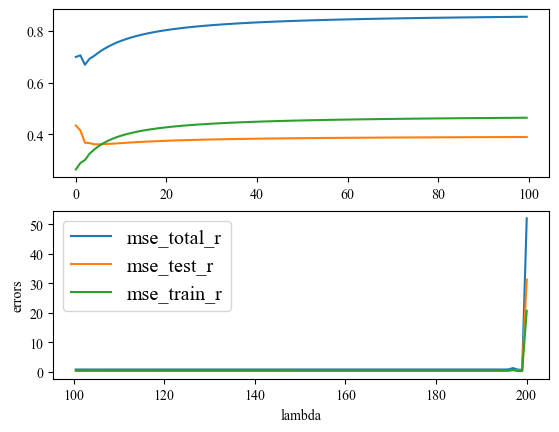

In [56]:
degree=50
alphatop=200
leng=200
poly=pf(degree=degree)
x_train_poly=poly.fit_transform(X_train)
X_test_poly=poly.fit_transform(X_test)
alpha=np.linspace(0,alphatop,leng)
mse_total_r = np.linspace(0, 10, leng)
mse_train_r = np.linspace(0, 10, leng)
mse_test_r = np.linspace(0, 10, leng)
for i in range(leng):
    lambda_reg=alpha[i]
    model=linearmodel(degree+1,1)
    optimize=L2SGD(model=model,lambda_reg=lambda_reg)
    loss_fn=MSE(model=model)
    fit(model=model,optimize=optimize,loss_fn=loss_fn,X_train=x_train_poly,y_train=y_train)
    y_pred_train=model(x_train_poly)
    m_train=loss_fn(input=y_pred_train,target=y_train)
    y_pred_test=model(X_test_poly)
    m_test=loss_fn(input=y_pred_test,target=y_test)
    mse_total_r[i]=m_test+m_train
    mse_train_r[i]=m_train
    mse_test_r[i]=m_test
    
plt.rc("font", family="times new roman")
plt.subplot(2,1,1)
plt.plot(alpha[:100], mse_total_r[:100], label="mse_total_r")
plt.plot(alpha[:100], mse_test_r[:100], label="mse_test_r")
plt.plot(alpha[:100], mse_train_r[:100], label="mse_train_r")
plt.subplot(2,1,2)
plt.plot(alpha[100:], mse_total_r[100:], label="mse_total_r")
plt.plot(alpha[100:], mse_test_r[100:], label="mse_test_r")
plt.plot(alpha[100:], mse_train_r[100:], label="mse_train_r")
plt.legend(fontsize="x-large")
plt.ylabel("errors")
plt.xlabel("lambda")
plt.show()
    

### As the logs show, the loss_end is smaller than the loss_start as is expected initially, as the lambda_reg increases the loss_end becomes much larger than less_begin. This is because the loss did not take regularization into account, however the optimization did. Hence the abonormal increase. 

### As the figure shows, with the lambda_reg increasing, the total_mse is slightly dropping at first, and finnally rocketing sky high. This indicates the process from underregularization to overregularization.